In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import time
from numba import jit
import math

## Rao-Blackwellization of the Metropolis-Hasting algorithm in the general case

Use this cell to define the function target, the distribution target, and a way to sample from these densities, do not use scipy !  
Since we want to estimate $\mathbb{E}[h(x)]$, we also need to define both h and the true mean. The functions h will be used in the comparative analysis part of this notebook

#### Student with 3 degree of freedom as the target distribution with a cauchy proposal centered on the last accepted sample

In [4]:
@jit(nopython=True)
def f_target(x,nu=3): #Student density with 3 degree of freedom
    coeff = 2 / (np.sqrt(3 * np.pi**2))
    density = coeff * (1 + (x**2) / nu) ** (-(nu + 1) / 2)
    return density

@jit(nopython=True)
def g_proposal(x,x0,scale): #Cauchy density
    return 1 / (np.pi * (1/scale) * (1 + ((x - x0) / (1/scale))**2))

@jit(nopython=True)
def f_sampling(): #Function to sample from f 
    return np.random.standard_t(3)

@jit(nopython=True)
def g_sampling(x0,scale): #function to sample from g
    return x0 + np.random.standard_cauchy() * (1/scale)

#To compute the mean of f 
@jit(nopython=True)
def h1(x):
    return x
true_mean1 = 0 #mean of f

#To compute tail probability of f
y = stats.t(3).ppf(0.95) #f.ppf(0.95) gives us y so that P(X>y)=0.05 where X has f for density
@jit(nopython=True)
def h2(x):
    return np.where(x>y,1,0) 
true_mean2 = 0.05 

xx = np.linspace(-6, 6, 250) #for the graph next cell

#### Normal target with mu=3,sigma=1 with a Normal proposal centered on the last accepted sample

#### Optimized version of the Metropolis-Hasting Algorithm :
This version used memory-preallocation and avoid recalculating the same densities. It is about 2 times faster than the previous one.

Acceptance Rate with sigma = 3 is 77.773 %
Average time to compute: 0.18496346473693848 seconds


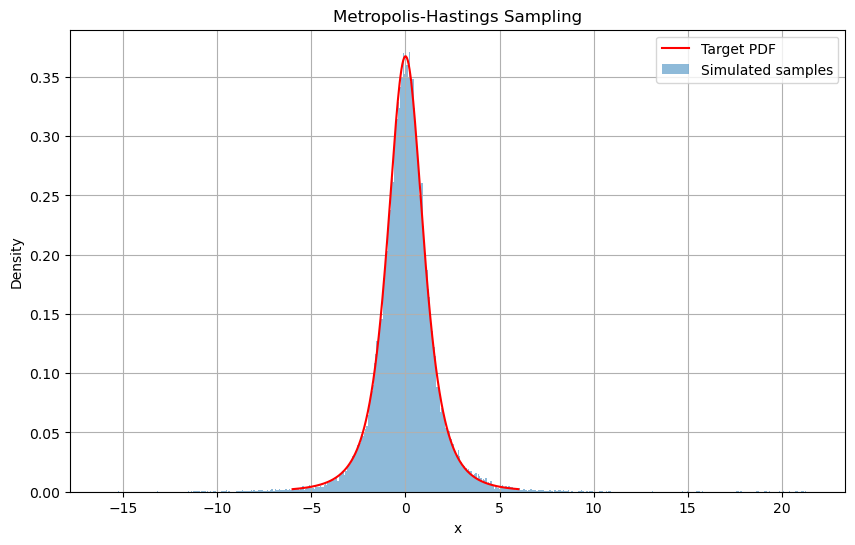

In [49]:
@jit(nopython=True)
def metropolis_hastings(numb_runs, num_samples, sigma, print_acceptance_rate=False):
    proposed_samples = np.zeros((numb_runs, num_samples + 1))
    accepted_samples = np.zeros((numb_runs, num_samples + 1))
    random_uniforms = np.random.rand(numb_runs, num_samples + 1)
    compteur_accept = 0
    

    for j in range(numb_runs):
        current_sample = f_sampling()  # Starting sample from the target
        accepted_samples[j, 0] = current_sample
        proposed_samples[j, 0] = current_sample
        f_current = f_target(current_sample)

        for i in range(1, num_samples + 1):
            proposal = g_sampling(current_sample, sigma) 
            g_current_to_proposal = g_proposal(current_sample, proposal, sigma)
            g_proposal_to_current = g_proposal(proposal, current_sample, sigma)
            

            f_proposed = f_target(proposal)

            # Calculate the acceptance ratio
            acceptance_ratio = (f_proposed / f_current) * (g_current_to_proposal / g_proposal_to_current)
            acceptance_ratio = min(1, acceptance_ratio)

            # Accept or reject the proposal
            if random_uniforms[j, i - 1] < acceptance_ratio:
                current_sample = proposal
                f_current = f_proposed
                compteur_accept += 1

            proposed_samples[j, i] = proposal
            accepted_samples[j, i] = current_sample

    if print_acceptance_rate:
        acceptance_rate = 100 * compteur_accept / (numb_runs * num_samples)
        print("Acceptance Rate with sigma =", sigma, "is", acceptance_rate, "%")
    return accepted_samples, proposed_samples

# Simulation parameters
numb_runs = 1
num_samples = 100000
sigma = 3

# Run the Metropolis-Hastings algorithm
start_time = time.time()
accepted_samples, proposed = metropolis_hastings(numb_runs, num_samples, sigma, print_acceptance_rate=True)
end_time = time.time()
print(f"Average time to compute: {(end_time - start_time) / numb_runs} seconds")

# Plotting results for one chain
plt.figure(figsize=(10, 6))
pdf_values = np.array([f_target(x) for x in xx])

plt.plot(xx, pdf_values, label="Target PDF", color="red")
plt.hist(accepted_samples[0, :], bins='auto', density=True, alpha=0.5, label="Simulated samples")
plt.legend()
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Metropolis-Hastings Sampling")
plt.grid()
plt.show()

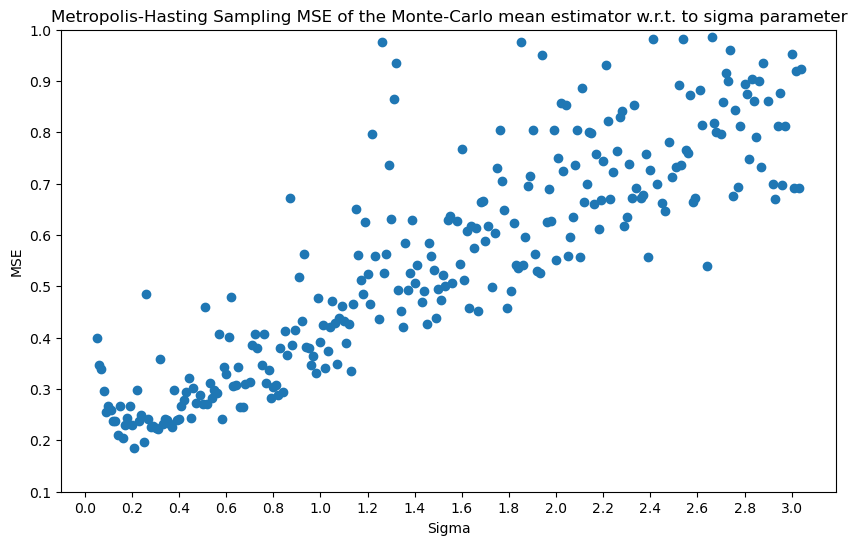

In [7]:
number_of_samples = 5000
sample_size = 100

mse_list = []

def calc_mse(est_array):
    return np.mean((np.array(est_array)-0)**2)

sigmas = np.arange(0.05,3.05,0.01)
for sigma in sigmas:
    accept_matrix,_ = metropolis_hastings(number_of_samples, sample_size, sigma)
    mc_est = []
    for j in range(number_of_samples):
        mc_est.append(np.mean(accept_matrix[j,:]))
    mse = calc_mse(mc_est)
    mse_list.append(mse)


plt.figure(figsize=(10, 6))    
plt.title("Metropolis-Hasting Sampling MSE of the Monte-Carlo mean estimator w.r.t. to sigma parameter")
plt.xlabel("Sigma")
plt.ylabel("MSE")
plt.scatter(sigmas,mse_list)
plt.ylim(0.1,1)
plt.xticks(np.arange(0,3.1,0.2))
plt.show()

### Implementation of the Rao-Blackwellized Monte Carlo, Importance-Sampling and Rao-Blackwellized Imp. Sampl. estimators :
This implementations takes advantage of numpy vectorization, memory pre-allocation (computing G,F,Rho in advance to avoid redundant calculations), and use JIT to maximize the computation speed. 

In [9]:
@jit(nopython=True)
def compute_G(Y,sigma):
    n = len(Y)
    G = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            G[i, j] = g_proposal(Y[i], Y[j], sigma) 
    return G

@jit(nopython=True)
def compute_F(Y):
    return f_target(Y)


@jit(nopython=True)
def compute_rho(Y,F,G):
    n = len(Y)
    rho = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            rho[i,j]= np.minimum(1, (F[j]/G[j,i])  /  (F[i]/G[i,j]))
    return rho


@jit(nopython=True)
def compute_rho_hat_star(Y, rho, G):
    n = len(Y)-1
    rho_hat_star = np.zeros((n, n))
    for i in range(n-1):
        for j in range(i + 1, n):
            rho_hat_star[i, j] = rho[i,j]*G[j+1,j]
    return rho_hat_star

@jit(nopython=True)
def compute_rho_star(Y, rho, G):
    n = len(Y)-1
    rho_star = np.zeros((n, n))
    for i in range(n-1):
        for j in range(i + 1, n):
            rho_star[i, j] = (1-rho[i,j])*G[j+1,i]
    return rho_star

@jit(nopython=True)
def compute_zeta(Y, rho_star):
    n = len(Y)-1
    zeta = np.eye(n)
    for i in range(n-1):
        for j in range(i + 1, n):
            zeta[i, j] = zeta[i, j-1]*rho_star[i,j]
    return zeta


@jit(nopython=True)
def compute_deltas(Y, zeta, rho_hat_star,rho):
    n = len(Y)-1
    deltas = np.zeros(n+1)
    deltas[0] = 1
    for j in range(1,n):
        sum_term = 0
        for t in range(j):
            sum_term += deltas[t] * zeta[t, j - 1] * rho_hat_star[t, j]
        deltas[j] = sum_term
    for t in range(n):
        deltas[n]+=deltas[t]*zeta[t,n-1]*rho[t,n]
    return deltas

@jit(nopython=True)
def compute_omega(Y,rho_hat_star, rho_star):
    n = len(Y)
    omegas = np.zeros((n, n))
    for i in range(n):
        omegas[n-1,i]=1
    for i in range(n - 2, 0, -1):
        for j in range(i):
            omegas[i, j] = rho_hat_star[j,i] * omegas[i + 1, i] + rho_star[j, i] * omegas[i + 1, j]
    return omegas


@jit(nopython=True)
def compute_phi(i, Y, rho, zeta, deltas, omegas):
    n = len(Y) - 1
    if i == n:
        return deltas[n]
    else:
        sum_term = 0
        for j in range(i, n):
            sum_term += zeta[i, j] * omegas[j+1, i]
        sum_term += zeta[i, n - 1] * (1 - rho[i, n])  
        return deltas[i] * sum_term

    
@jit(nopython=True)
def rao_blackwell_estimator(Y,sigma,h):
    
    F = compute_F(Y)
    G = compute_G(Y,sigma)
    rho = compute_rho(Y, F, G)
    rho_hat_star = compute_rho_hat_star(Y, rho, G)
    rho_star = compute_rho_star(Y, rho, G)
    zeta = compute_zeta(Y, rho_star)
    deltas = compute_deltas(Y, zeta, rho_hat_star, rho)
    omegas = compute_omega(Y, rho_hat_star, rho_star)
    n = len(Y) - 1

    den=0
    for i in range(n):
        den += deltas[i] * zeta[i, n-1]
        

    num=0
    for i in range(n + 1):
        phi_i = compute_phi(i, Y, rho, zeta, deltas, omegas)
        num += phi_i * h(Y[i])

    return (num / den) /(n+1)

@jit(nopython=True)
def rao_blackwell_importance_sampling_estimator(Y,sigma,h):
    
    F = compute_F(Y)
    G = compute_G(Y,sigma)
    rho = compute_rho(Y, F, G)
    rho_hat_star = compute_rho_hat_star(Y, rho, G)
    rho_star = compute_rho_star(Y, rho, G)
    zeta = compute_zeta(Y, rho_star)
    deltas = compute_deltas(Y, zeta, rho_hat_star, rho)
    omegas = compute_omega(Y, rho_hat_star, rho_star)
    
    
    temp = h(Y[0]) + h(Y[1])*F[1]/G[1,0]

    n = len(Y)-1
    den = 0
    for i in range(n):
        den+= deltas[i]*zeta[i,n-1]

    num = 0
    for i in range(2,n+1):
        for j in range(0,i):
            num+= F[i]*deltas[j]*zeta[j,i-2]*omegas[i,j]*h(Y[i])
    return (temp+(num/den))/(n+1)


@jit(nopython=True)
def importance_sampling_estimator(accept,proposal,sigma,h):

    n = len(proposal)-1
    est = 0
    for j in range(1,n+1):
        
        est+= ( f_target(proposal[j])/g_proposal(proposal[j], accept[j-1], sigma) )*h(proposal[j])/(n+1)
    return est

def monte_carlo_estimator(accept,h):
    return np.sum(np.array(h(accept)))/(len(accept))

In [10]:
#Parameters
number_of_samples = 10000
sample_size = 100
sigma = 3
h = h2
true_mean = true_mean2

# Collect the samples
accept_samples, proposal_samples = metropolis_hastings(number_of_samples,sample_size,sigma)


#Main computation
res_RB = []
res_MC = []
res_IS = []
res_IS_RB = []

for j,sample in enumerate(proposal_samples):

    # Classic MC estimator 
    res_MC.append(monte_carlo_estimator(accept_samples[j],h))

    # Rao-Blackwellized MH estimator 
    res_RB.append(rao_blackwell_estimator(sample,sigma,h))
    
    # Import. Sampl. estimator 
    res_IS.append(importance_sampling_estimator(accept_samples[j],sample,sigma,h))
    
    # Rao-Blackwellized IS estimator 
    res_IS_RB.append(rao_blackwell_importance_sampling_estimator(sample,sigma,h))



# Display the means
print(f"Target mean: {true_mean}")
print(f"Classic MC empirical average mean: {np.mean(res_MC):.5f}")
print(f"Rao-Blackwell empirical average mean: {np.mean(res_RB):.5f}")
print(f"Importance Sampling empirical average mean: {np.mean(res_IS):.5f}")
print(f"Rao-Blackwell Imp. Samp. average mean: {np.mean(res_IS_RB):.5f}")

# Compute and display the MSEs
classic_mc_mse = np.mean((np.array(res_MC) - true_mean) ** 2)
rao_blackwell_mse = np.mean((np.array(res_RB) - true_mean) ** 2)
importance_sampling_mse = np.mean((np.array(res_IS) - true_mean) ** 2)
RB_importance_sampling_mse = np.mean((np.array(res_IS_RB) - true_mean) ** 2)

print(f"\nClassic MC MSE: {classic_mc_mse:.5f}")
print(f"Rao-Blackwell MSE: {rao_blackwell_mse:.5f}")
print(f"Importance Sampling MSE: {importance_sampling_mse:.5f}")
print(f"Rao-Blackwell Imp. Samp. MSE: {RB_importance_sampling_mse:.5f}")

# Compute MSE decrease percentages
mse_decrease_rb = classic_mc_mse - rao_blackwell_mse
percent_decrease_rb = (mse_decrease_rb / classic_mc_mse) * 100

mse_decrease_is = classic_mc_mse - importance_sampling_mse
percent_decrease_is = (mse_decrease_is / classic_mc_mse) * 100

mse_decrease_rb_is = classic_mc_mse - RB_importance_sampling_mse
percent_decrease_rb_is = (mse_decrease_rb_is / classic_mc_mse) * 100

print("")
print(f"Percentage decrease in MSE (Rao-Blackwell vs Classic MC): {percent_decrease_rb:.2f}%")
print(f"Percentage decrease in MSE (Importance Sampling vs Classic MC): {percent_decrease_is:.2f}%")
print(f"Percentage decrease in MSE (Rao-Blackwell Imp. Samp. vs Classic MC): {percent_decrease_rb_is:.2f}%")

Target mean: 0.05
Classic MC empirical average mean: 0.04933
Rao-Blackwell empirical average mean: 0.04931
Importance Sampling empirical average mean: 0.04937
Rao-Blackwell Imp. Samp. average mean: 0.04990

Classic MC MSE: 0.00960
Rao-Blackwell MSE: 0.00958
Importance Sampling MSE: 0.00104
Rao-Blackwell Imp. Samp. MSE: 0.00173

Percentage decrease in MSE (Rao-Blackwell vs Classic MC): 0.22%
Percentage decrease in MSE (Importance Sampling vs Classic MC): 89.19%
Percentage decrease in MSE (Rao-Blackwell Imp. Samp. vs Classic MC): 82.02%


## Comparative Analysis of Estimation Techniques: Classic Monte Carlo, Rao-Blackwell Metropolis Hasting, Importance Sampling, and Rao Blackwell Imp. Sampl. :

In [12]:
samples_sizes = [5,10,25,50,100,150]
number_of_samples = 50000
sigmas = [0.34,2.5]

Matrix_res_33_h1 = np.zeros((len(samples_sizes),8))
Matrix_res_75_h1 = np.zeros((len(samples_sizes),8))
Matrix_res_33_h2 = np.zeros((len(samples_sizes),8))
Matrix_res_75_h2 = np.zeros((len(samples_sizes),8))

for h,true_mean in zip([h1,h2],[true_mean1,true_mean2]):
    for c,sigma in enumerate(sigmas):

        if true_mean == true_mean1:
            Matrix_res = Matrix_res_33_h1 if sigma==0.34 else Matrix_res_75_h1
        else : 
            Matrix_res = Matrix_res_33_h2 if sigma==0.34 else Matrix_res_75_h2
            
        for i,s in enumerate(samples_sizes) : 
            res_RB = []
            res_MC = []
            res_IS = []
            res_IS_RB = []
            
            for j in range (number_of_samples):
        
                accept,propos = metropolis_hastings(1,s,sigma)
                accept=accept[0,:]
                propos=propos[0,:]
                Y = propos
           
                # Classic MC estimator 
                res_MC.append(monte_carlo_estimator(accept,h))
                # Rao-Blackwellized estimator 
                res_RB.append(rao_blackwell_estimator(Y,sigma,h))
    
                # Importance Sampling estimator 
                res_IS.append(importance_sampling_estimator(accept,propos,sigma,h))
                
                # Rao-Blackwellized Import. Sampl. estimator 
                res_IS_RB.append(rao_blackwell_importance_sampling_estimator(Y,sigma,h))
                
            progress_message = f"Progress: {(c+1)*(i+1)}/{2*len(samples_sizes)}"
            print(progress_message.ljust(50), end='\r')
    
            
            
            Matrix_res[i,0]=np.mean(res_MC)
            Matrix_res[i,1]=np.mean(res_RB)
            Matrix_res[i,2]=np.mean(res_IS)
            Matrix_res[i,3]=np.mean(res_IS_RB)
            
        
            classic_mc_mse = np.mean((np.array(res_MC) - true_mean) ** 2)
            rao_blackwell_mse = np.mean((np.array(res_RB) - true_mean) ** 2)
            importance_sampling_mse = np.mean((np.array(res_IS) - true_mean) ** 2)
            rb_importance_sampling_mse = np.mean((np.array(res_IS_RB) - true_mean) ** 2)
        
            Matrix_res[i,4]=classic_mc_mse
            
            
            # Compute MSE decrease percentages
            mse_decrease_rb = classic_mc_mse - rao_blackwell_mse
            percent_decrease_rb = (mse_decrease_rb / classic_mc_mse) * 100
            
            mse_decrease_is = classic_mc_mse - importance_sampling_mse
            percent_decrease_is = (mse_decrease_is / classic_mc_mse) * 100
    
            mse_decrease_is_rb = classic_mc_mse - rb_importance_sampling_mse
            percent_decrease_is_rb = (mse_decrease_is_rb / classic_mc_mse) * 100
            
            Matrix_res[i,5]=percent_decrease_rb
            Matrix_res[i,6]=percent_decrease_is
            Matrix_res[i,7]=percent_decrease_is_rb

#### Estimation of the mean of the target distribution with acceptance rate 33% over 50000 runs:

In [14]:
results = [
    'MC Metrop.',
    'RB Metrop.',
    'Imp. sampl.',
    'RB import. sampl.',
    'MSE Metrop.',
    'MSE decrease RB over MC (%)',
    'MSE decrease IS over MC (%)',
    'MSE decrease RB-IS over MC (%)']

df_results = pd.DataFrame(Matrix_res_33_h1, index=samples_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MC Metrop.,RB Metrop.,Imp. sampl.,RB import. sampl.,MSE Metrop.,MSE decrease RB over MC (%),MSE decrease IS over MC (%),MSE decrease RB-IS over MC (%)
Sample size,,,,,,,,
5,-0.00122,0.00029,0.00020,0.00116,2.17003,9.89697,86.11776,82.60298
10,-0.00445,-0.00061,0.00335,0.00332,1.44681,10.68952,87.72777,86.71635
25,0.00612,0.00438,0.00018,0.00049,0.87140,9.74096,90.67833,90.81646
50,0.00374,0.00478,0.00095,0.00080,0.46951,10.05770,90.79187,91.25767
100,-0.00084,-0.00164,0.00094,0.00118,0.32046,7.07623,93.52969,93.83271
150,-0.00167,-0.00123,-0.00068,-0.00061,0.18074,8.16088,92.30050,92.73913


#### Estimation of the mean of the target distribution with acceptance rate 75% over 50000 runs:

In [16]:
df_results = pd.DataFrame(Matrix_res_75_h1, index=samples_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MC Metrop.,RB Metrop.,Imp. sampl.,RB import. sampl.,MSE Metrop.,MSE decrease RB over MC (%),MSE decrease IS over MC (%),MSE decrease RB-IS over MC (%)
Sample size,,,,,,,,
5,-0.00365,-0.00341,-0.00058,0.00035,2.50718,0.49261,63.68998,52.07422
10,0.00520,0.00509,0.00277,0.00434,2.83706,0.25945,81.96415,79.06960
25,-0.00324,-0.00347,0.00073,0.00152,1.72973,0.14186,85.90523,83.42526
50,0.00027,0.00018,-0.00327,-0.00450,1.16148,0.14390,88.61638,86.15119
100,-0.00751,-0.00736,-0.00048,0.00040,0.76553,0.08600,91.45300,89.14861
150,-0.00296,-0.00303,0.00039,0.00083,0.71432,0.10976,94.24283,92.92855


#### Estimation of the tail of the target distribution choosen to be 0.05 with acceptance rate 33% over 50000 runs:

In [18]:
df_results = pd.DataFrame(Matrix_res_33_h2, index=samples_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MC Metrop.,RB Metrop.,Imp. sampl.,RB import. sampl.,MSE Metrop.,MSE decrease RB over MC (%),MSE decrease IS over MC (%),MSE decrease RB-IS over MC (%)
Sample size,,,,,,,,
5,0.04967,0.04906,0.04145,0.04973,0.02793,22.08169,90.28697,86.04199
10,0.05045,0.05062,0.04536,0.04982,0.02073,23.64584,92.34743,90.76594
25,0.05067,0.05047,0.04805,0.05000,0.01116,24.92345,93.54335,93.16842
50,0.04979,0.04998,0.04907,0.04995,0.00609,23.71373,93.83693,93.79642
100,0.05013,0.05022,0.04949,0.04995,0.00322,23.70197,94.08271,94.16521
150,0.05027,0.05019,0.04966,0.04998,0.00219,23.22122,94.15185,94.27165


#### Estimation of the tail of the target distribution choosen to be 0.05 with acceptance rate 75% over 50000 runs:

In [20]:
df_results = pd.DataFrame(Matrix_res_75_h2, index=samples_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(4)

,MC Metrop.,RB Metrop.,Imp. sampl.,RB import. sampl.,MSE Metrop.,MSE decrease RB over MC (%),MSE decrease IS over MC (%),MSE decrease RB-IS over MC (%)
Sample size,,,,,,,,
5,0.0516,0.0516,0.0414,0.0506,0.0367,2.1840,64.5468,46.8333
10,0.0477,0.0479,0.0456,0.0502,0.0285,1.5043,74.1303,54.7709
25,0.0508,0.0507,0.0480,0.0497,0.0217,1.0860,84.6098,78.7825
50,0.0506,0.0506,0.0488,0.0496,0.0142,0.6623,87.8949,81.7897
100,0.0497,0.0498,0.0495,0.0502,0.0082,0.5344,89.3915,82.6107
150,0.0503,0.0503,0.0496,0.0499,0.0058,0.7048,89.8564,85.1231


#### How many more sample do we have to generate using MH to achieve the same MSE as the Rao-Blackwell estimator with samples size = 100 ?

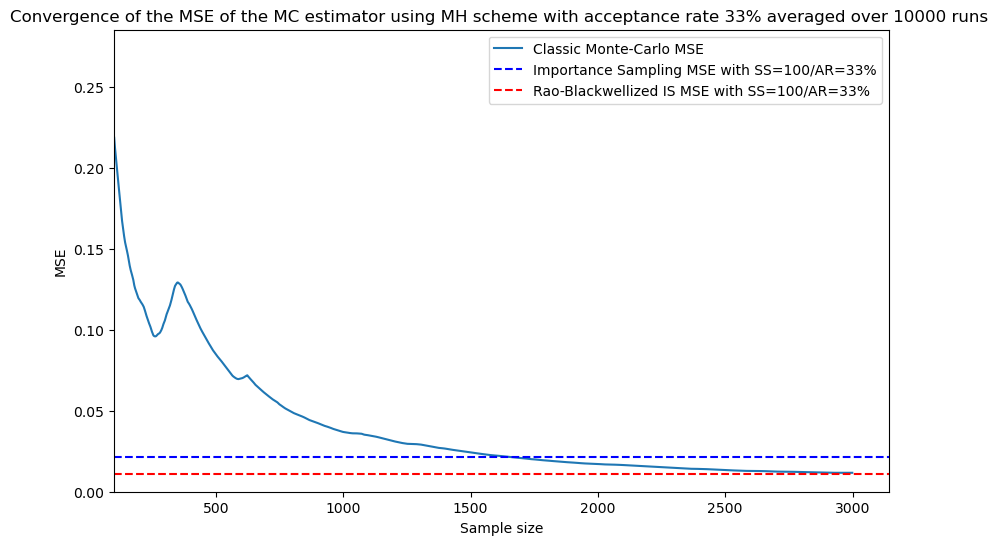

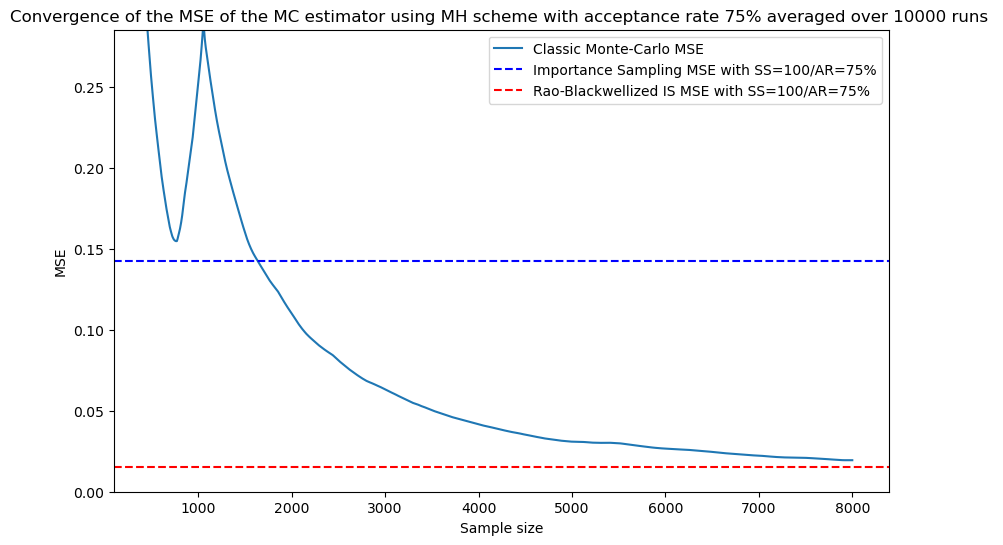

In [22]:
# Parameters
MSE_values_is = [0.02126, 0.14260]
MSE_values_is_rb = [0.01100, 0.01556]
h = h1
true_mean = true_mean1
number_of_samples = 10000
sigmas = [0.34,2.5]
AR = ['33%','75%']

for k,sigma in enumerate(sigmas):
    
    tt = np.arange(100, 3000+k*5000, 1)
    mse_mh = np.zeros(len(tt))
    
    for j in range(number_of_samples):
        
        accept, _ = metropolis_hastings(1,len(tt), sigma) 
        accept = accept[0,:]
        # For each t in tt, calculate MSE from the start of the chain up to t
        for i,t in enumerate(tt):
            subset_accept = accept[:t]
            MC_estimate = ((monte_carlo_estimator(subset_accept,h) - true_mean) ** 2)/number_of_samples
            mse_mh[i]+= MC_estimate
    
        # Progress indicator
        progress = 100 * (j + 1) / number_of_samples
        print(f"Progress: {progress:.2f}%".ljust(50), end='\r')
    
    
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(tt, mse_mh, label='Classic Monte-Carlo MSE')
    plt.axhline(y=MSE_values_is[k], color='b', linestyle='--', label=f'Importance Sampling MSE with SS=100/AR={AR[k]}')
    plt.axhline(y=MSE_values_is_rb[k], color='r', linestyle='--', label=f'Rao-Blackwellized IS MSE with SS=100/AR={AR[k]}')
    plt.legend()
    plt.ylim(0, 2 * MSE_values_is[1])
    plt.xlim(100)
    plt.xlabel('Sample size')
    plt.ylabel('MSE')
    plt.title(f"Convergence of the MSE of the MC estimator using MH scheme with acceptance rate {AR[k]} averaged over {number_of_samples} runs ")
    plt.show()


#### Computation time comparison for the four estimators

In [24]:
# Parameters
size = [1500,3000,1500,10000]
number_of_samples = 5000  # Number of runs for the average computation time and MSE
sigmas = [0.34,2.5]
h = h1
true_mean = true_mean1 # True mean for MSE calculation

results = []

compteur = 1
# Classic Monte Carlo MSE and time computation 
for k,s in enumerate(size):
    
    sigma = 0.34 if (k==0 or k==1) else 2.5
    
    
    start_time = time.time()
    mse_classic_mc = 0
        
    for i in range(number_of_samples):
        accept, _ = metropolis_hastings(1,s,sigma)
        temp = np.mean(accept)
        mse_classic_mc += (temp - true_mean) ** 2  # Accumulate squared error
        
    
    mse_classic_mc /= number_of_samples
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples  

    results.append({
        "Estimator": "Classic MC",
        "Size": s,
        "Sigma": sigma,
        "Time (s)": loop_time,
        "MSE": mse_classic_mc
    })
    compteur+=1

#Importance Sampling and Rao-BlackWell Imp. Sampl. MSE and times computation
for k,sigma in enumerate(sigmas):
    
    start_time = time.time()
    samples_proposal = []
    samples_accept, samples_proposal = metropolis_hastings(number_of_samples,100,sigma)
    
    res = []
    for j in range(number_of_samples):
    
        res.append(rao_blackwell_importance_sampling_estimator(samples_proposal[j,:],sigma,h))
        
        

    mse_importance_sampling = np.mean((np.array(res) - true_mean) ** 2)
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples

    results.append({
        "Estimator": "RB Importance Sampling",
        "Size": 100,
        "Sigma": sigma,
        "Time (s)": loop_time,
        "MSE": mse_importance_sampling
        })
    compteur+=1
    
    start_time = time.time()
    samples_accept = []
    samples_proposal = []
    
    samples_accept, samples_proposal = metropolis_hastings(number_of_samples,100,sigma)
       
    
    res = []
    for j in range(number_of_samples):
    
        res.append(importance_sampling_estimator(samples_accept[j,:],samples_proposal[j,:],sigma,h))
    
        

    mse_importance_sampling = np.mean((np.array(res) - true_mean) ** 2)
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples

    results.append({
        "Estimator": "Importance Sampling",
        "Size": 100,
        "Sigma": sigma,
        "Time (s)": loop_time,
        "MSE": mse_importance_sampling
        })
    compteur+=1


print("Results :")
results_df = pd.DataFrame(results)
df_rate_33 = results_df[results_df["Sigma"] == 0.34].round(5)
df_rate_75 = results_df[results_df["Sigma"] == 2.5].round(5)

print("Results for Acceptance rate 33%")
print(df_rate_33)
print("\nResults for Acceptance rate 75%")
print(df_rate_75)
#Those value should be re-organized properly in the report 

Results :
Results for Acceptance rate 33%
                Estimator  Size  Sigma  Time (s)      MSE
0              Classic MC  1500   0.34   0.00012  0.01796
1              Classic MC  3000   0.34   0.00023  0.00940
4  RB Importance Sampling   100   0.34   0.00008  0.01949
5     Importance Sampling   100   0.34   0.00001  0.02057

Results for Acceptance rate 75%
                Estimator   Size  Sigma  Time (s)      MSE
2              Classic MC   1500    2.5   0.00011  0.08499
3              Classic MC  10000    2.5   0.00072  0.01442
6  RB Importance Sampling    100    2.5   0.00009  0.07363
7     Importance Sampling    100    2.5   0.00001  0.06292
